## Getting Started

- Download MapPLUTO data from [NYC DCP](https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/nyc_mappluto_24v1_1_shp.zip)
- Unzip the file and place contents in the `Data` directory at the root of this repo
- Make sure you have installed all requisite libraries by running `pip install -r requirements.txt` **_with your virtual environment activated_**

## Goals

- Load data from file
- Explore spatial and non-spatial elements of the dataset
- Compare tradeoffs between different methods of loading data
- Demonstrate tradeoffs in different file formats


In [1]:
# the bare minimum
import matplotlib.pyplot as plt
import geopandas as gpd

# more advanced
import pyogrio as ogr
from sklearn.cluster import KMeans
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap, apply_continuous_cmap
from palettable.colorbrewer.sequential import PuRd_9
from matplotlib.colors import LogNorm

import pydeck as pdk

# load PLUTO data


In [13]:
wifi = gpd.read_file("C:/Users/daiyu/Documents/GitHub/cdp-mapping-systems/Data/NYC Wi-Fi Hotspot Locations/geo_export_7bd69aeb-db99-40f4-9406-ec6aed37364b.shp")

In [14]:
wifi.head(3)

,date_activ,time_activ,bbl,bin,boro,borocd,borocode,boroct2010,boroname,city,...,objectid,postcode,provider,remarks,sourceid,ssid,type,x,y,geometry
0,2017-11-21,00:00:00.000,3.041480e+09,3327234.0,BK,305.0,3.0,3118400.0,Brooklyn,Brooklyn,...,10321.0,11208.0,LinkNYC - Citybridge,"Tablet Internet -phone , Free 1 GB Wi-FI Service",LINK-021921,LinkNYC Free Wi-Fi,Free,1.020156e+06,188524.768013,POINT (-73.87054 40.68406)
1,2017-11-21,00:00:00.000,3.041340e+09,3092471.0,BK,305.0,3.0,3118400.0,Brooklyn,Brooklyn,...,10322.0,11208.0,LinkNYC - Citybridge,"Tablet Internet -phone , Free 1 GB Wi-FI Service",LINK-021922,LinkNYC Free Wi-Fi,Free,1.020589e+06,188730.985121,POINT (-73.86897 40.68463)
2,2017-11-21,00:00:00.000,3.041510e+09,3093023.0,BK,305.0,3.0,3118400.0,Brooklyn,Brooklyn,...,10323.0,11208.0,LinkNYC - Citybridge,"Tablet Internet -phone , Free 1 GB Wi-FI Service",LINK-021923,LinkNYC Free Wi-Fi,Free,1.020774e+06,188759.119907,POINT (-73.86831 40.68470)


<Axes: xlabel='boro'>

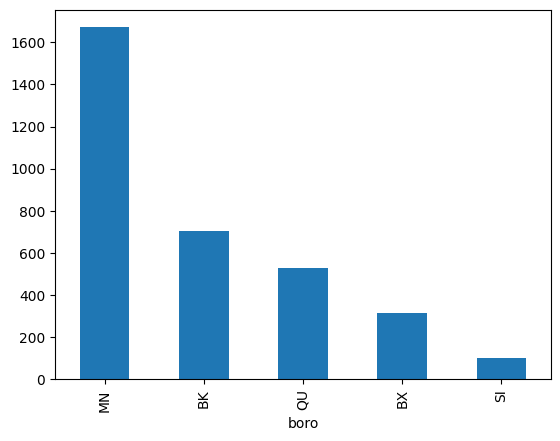

In [15]:
wifi.groupby("boro").size().sort_values(ascending=False).plot.bar()

In [4]:
pluto_ogrio = ogr.read_dataframe(r"C:\Users\daiyu\Documents\GitHub\cdp-mapping-systems\Data\NYC Wi-Fi Hotspot Locations\geo_export_7bd69aeb-db99-40f4-9406-ec6aed37364b.shp")

# basic exploration


In [5]:
pluto_ogrio.columns

Index(['date_activ', 'time_activ', 'bbl', 'bin', 'boro', 'borocd', 'borocode',
       'boroct2010', 'boroname', 'city', 'coundist', 'ct2010', 'doitt_id',
       'lat', 'location', 'location_t', 'lon', 'name', 'ntacode', 'ntaname',
       'objectid', 'postcode', 'provider', 'remarks', 'sourceid', 'ssid',
       'type', 'x', 'y', 'geometry'],
      dtype='object')

In [6]:
pluto_ogrio.dtypes

date_activ      object
time_activ      object
bbl            float64
bin            float64
boro            object
borocd         float64
borocode       float64
boroct2010     float64
boroname        object
city            object
coundist       float64
ct2010         float64
doitt_id       float64
lat            float64
location        object
location_t      object
lon            float64
name            object
ntacode         object
ntaname         object
objectid       float64
postcode       float64
provider        object
remarks         object
sourceid        object
ssid            object
type            object
x              float64
y              float64
geometry      geometry
dtype: object

## categorical column


In [7]:
pluto_ogrio.boro.value_counts()

boro
MN    1671
BK     702
QU     530
BX     316
SI     100
Name: count, dtype: int64

🧐 What do those numbers mean? Let's look at the [data dictionary](https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/meta_mappluto.pdf)


In [8]:
# now we can remap the numbers into something more meaningful

boro_codes = {
    "01": "MN",
    "02": "BK",
    "03": "QU",
    "04": "BX",
    "05": "SI",
}

In [9]:
pluto_ogrio["boro"] = pluto_ogrio.boro.map(boro_codes)

## Your turn:

- How many lots of each land use type are there?
  - Use `groupby` to determine the number of lots of each land use type
- What is the lot area of each land use type?
  - Use `groupby` to make a bar chart that shows the average lot area of each land use type
- Can you find the total number of lots that contain `Commercial & Office Buildings` in the Bronx?
  - use groupby on multiple columns to achieve this
- Can you find the share of each land use type in each borough?


In [ ]:
pluto_ogrio.groupby("LandUse").LotArea.sum().sort_values(ascending=False).plot.bar()

In [10]:
pluto_ogrio.groupby(["boro","objectid"])

## Okay, now let's look at lot and building area


IndexError: index 0 is out of bounds for axis 0 with size 0

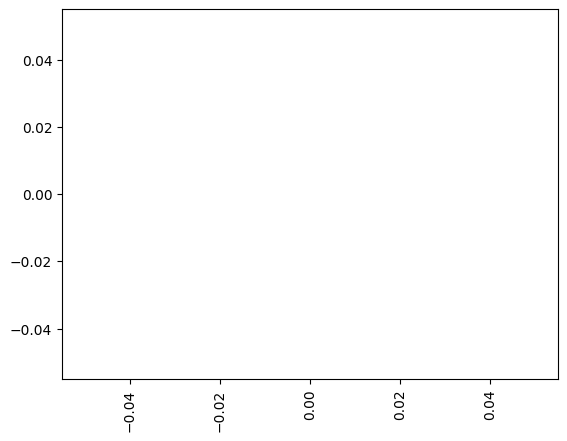

In [11]:
pluto_ogrio.groupby("boro").objectid.sum().sort_values(ascending=False).plot.bar()
plt.title("doitt_id by boro")

Text(0.5, 1.0, 'Total building area by land use type')

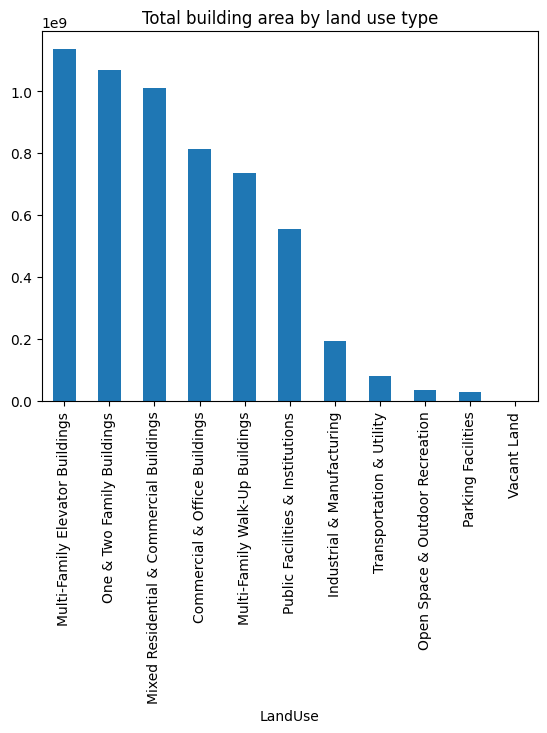

In [12]:
# now the same but for building area
pluto_ogrio.groupby("LandUse").BldgArea.sum().sort_values(ascending=False).plot.bar()
plt.title("Total building area by land use type")

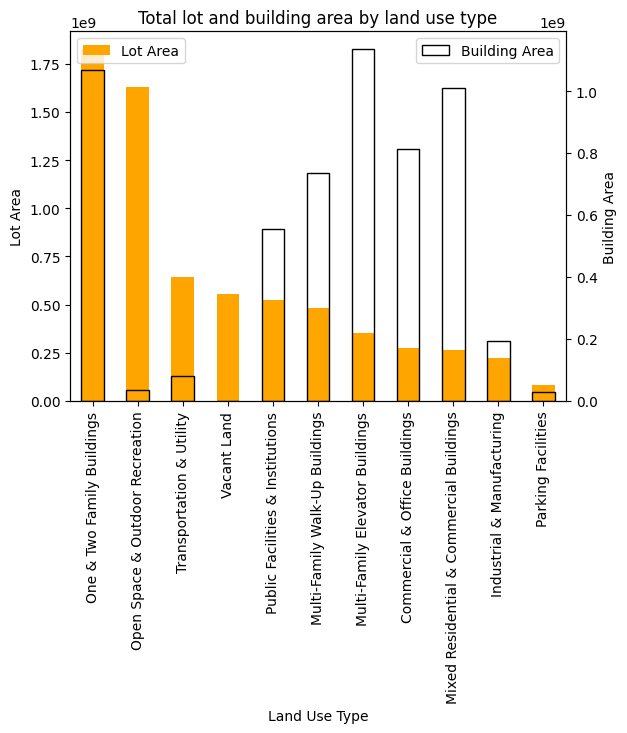

In [13]:
# plot both lot and building area on the same plot with a secondary y-axis
fig, ax = plt.subplots()
by_lot_area = pluto_ogrio.groupby("LandUse").LotArea.sum().sort_values(ascending=False)

by_lot_area.plot.bar(ax=ax, color="orange")

# get order to apply below
order = {v: i for i, v in enumerate(by_lot_area.index)}

ax.set_ylabel("Lot Area")
ax.set_xlabel("Land Use Type")

ax2 = ax.twinx()
pluto_ogrio.groupby("LandUse").BldgArea.sum().reindex(by_lot_area.index).plot.bar(
    ax=ax2, edgecolor="black", color="none"
)
ax2.set_ylabel("Building Area")

plt.title("Total lot and building area by land use type")

# add legends
ax.legend(["Lot Area"], loc="upper left")
ax2.legend(["Building Area"], loc="upper right")

## numeric column


In [14]:
pluto_ogrio.NumFloors.nunique()

176

In [15]:
pluto_ogrio["NumFloors"].describe()

count    856819.000000
mean          2.357554
std           2.012707
min           0.000000
25%           2.000000
50%           2.000000
75%           2.500000
max         104.000000
Name: NumFloors, dtype: float64

<Axes: ylabel='Frequency'>

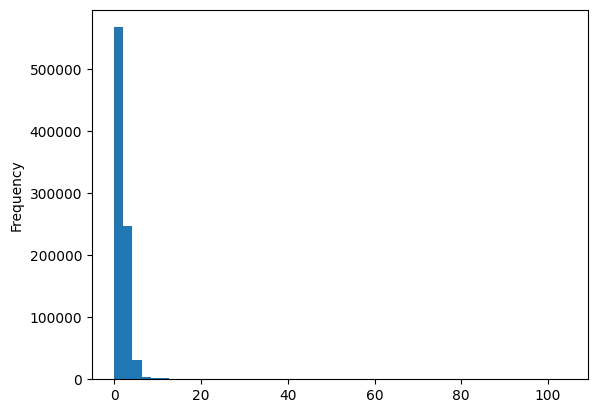

In [16]:
pluto_ogrio["NumFloors"].plot.hist(bins=50)

## Your turn:

- make a histogram for each borough like above
- then, choose another chart type to visualize the distribution of lot area for each borough. See [here](https://matplotlib.org/stable/plot_types/index.html) for some built in options in matplotlib, or here for [seaborn](https://seaborn.pydata.org/tutorial/distributions.html)


## Ok, now let's make a boxplot to see how wide the range is within each boro's data


<Axes: title={'center': 'NumFloors'}, xlabel='Borough'>

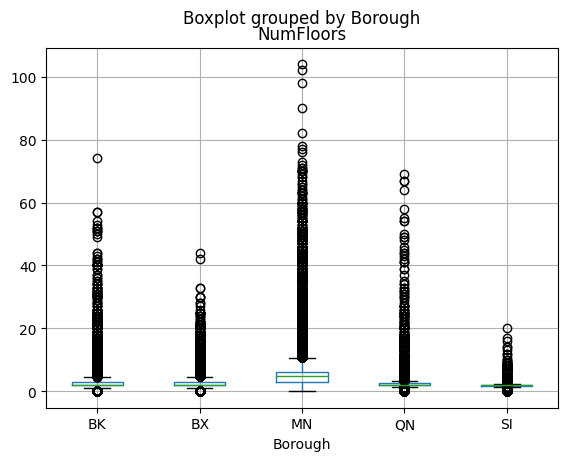

In [17]:
pluto_ogrio.boxplot(column="NumFloors", by="Borough")

What does this distribution tell us about the number of floors in each borough?


# cluster by number of floors


In [18]:
# get clusters using kmeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(pluto_ogrio[["NumFloors", "ResArea"]])

pluto_ogrio["NumFloorsCluster"] = kmeans.predict(pluto_ogrio[["NumFloors", "ResArea"]])

c:\Users\daiyu\.conda\envs\cdp_mapping\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\daiyu\.conda\envs\cdp_mapping\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\daiyu\.conda\envs\cdp_mapping\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\daiyu\.conda\envs\cdp_mapping\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\daiyu\.conda\envs\cdp_mapping\Lib\subprocess.py",

In [19]:
pluto_ogrio.groupby("NumFloorsCluster").NumFloors.describe().sort_values("max")

,count,mean,std,min,25%,50%,75%,max
NumFloorsCluster,,,,,,,,
2,3.0,20.000000,11.269428,13.0,13.5,14.0,23.5,33.0
4,35.0,18.985714,11.616726,0.0,13.5,18.0,24.5,46.0
3,8510.0,9.900558,7.227621,0.0,6.0,6.0,13.0,82.0
1,867.0,23.617070,15.759391,0.0,13.0,20.0,33.0,98.0
0,847404.0,2.259303,1.501984,0.0,2.0,2.0,2.5,104.0


<Axes: xlabel='NumFloors', ylabel='ResArea'>

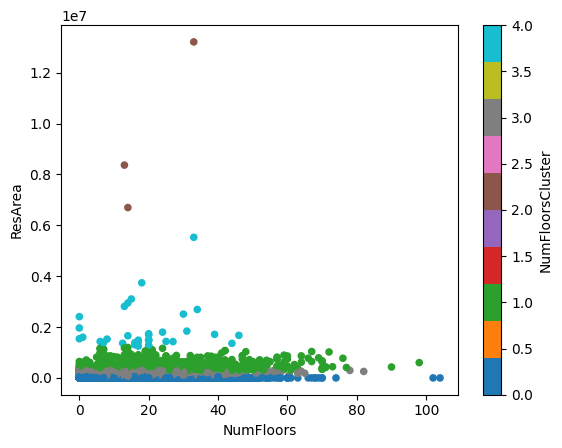

In [20]:
pluto_ogrio.plot.scatter(x="NumFloors", y="ResArea", c="NumFloorsCluster", cmap="tab10")

<Axes: xlabel='NumFloors', ylabel='ResArea'>

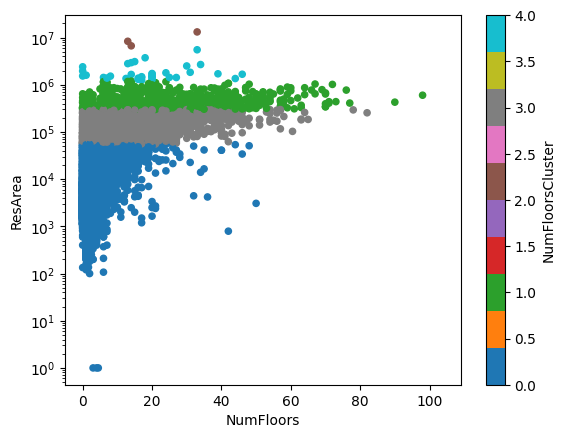

In [21]:
# same as above but with log y axis
pluto_ogrio.plot.scatter(
    x="NumFloors", y="ResArea", c="NumFloorsCluster", cmap="tab10", logy=True
)

<Axes: ylabel='Frequency'>

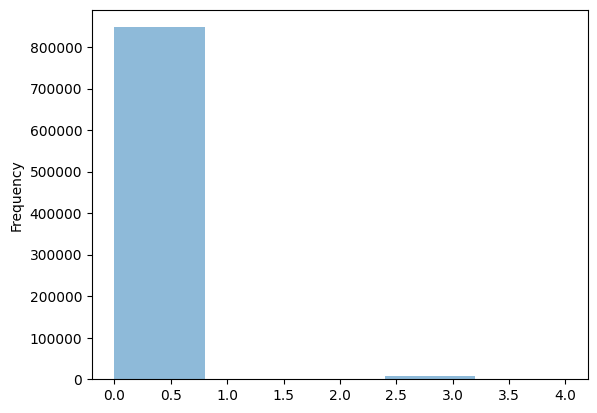

In [22]:
pluto_ogrio["NumFloorsCluster"].plot.hist(bins=5, alpha=0.5)

# and now, mapping


## static map


Text(0.5, 1.0, 'NYC wifi spots')

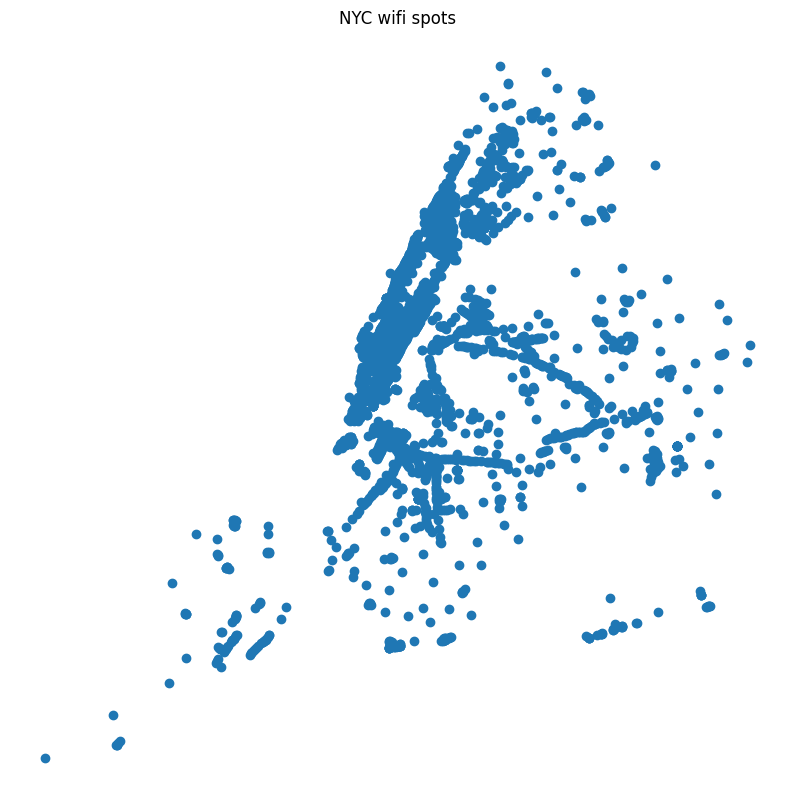

In [17]:
pluto_ogrio.plot(figsize=(10, 10)).set_axis_off()
plt.title("NYC wifi spots")

In [24]:
cmap = {
    "One & Two Family Buildings": "#ff0000",
    "Multi-Family Walk-Up Buildings": "#00ff00",
    "Multi-Family Elevator Buildings": "#0000ff",
    "Mixed Residential & Commercial Buildings": "#ff00ff",
    "Commercial & Office Buildings": "#00ffff",
    "Industrial & Manufacturing": "#ffff00",
    "Transportation & Utility": "#808080",
    "Public Facilities & Institutions": "#800000",
    "Open Space & Outdoor Recreation": "#008000",
    "Parking Facilities": "#000080",
    "Vacant Land": "#800080",
    "Unknown": "#000000",
}

In [25]:
pluto_ogrio.fillna({"LandUse": "Unknown"}, inplace=True)

In [26]:
pluto_ogrio["color"] = pluto_ogrio["LandUse"].map(cmap)

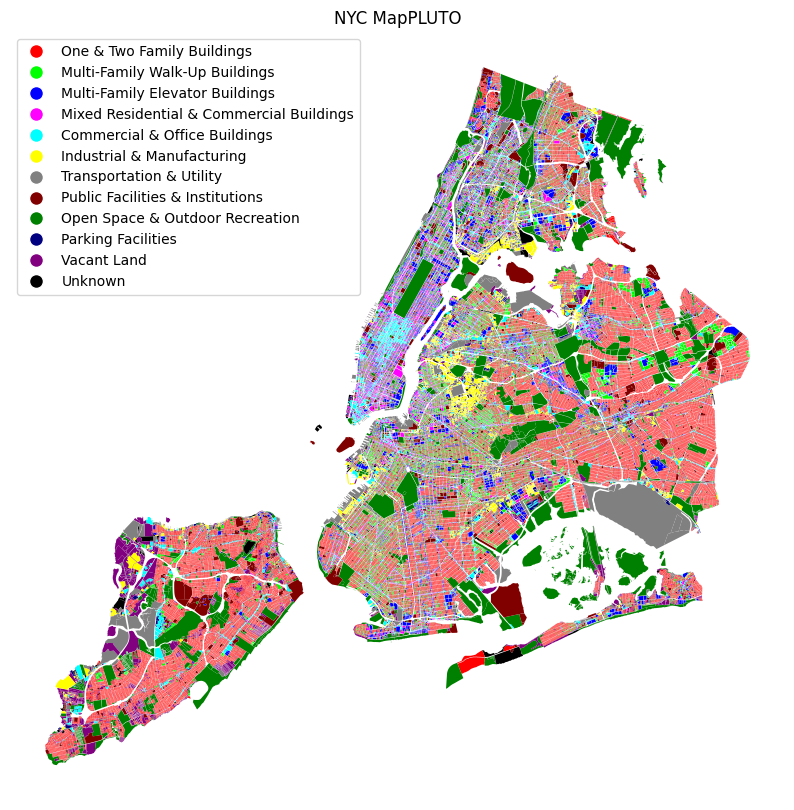

In [27]:
ax = pluto_ogrio.plot(
    color=pluto_ogrio["color"],
    figsize=(10, 10),
    legend=True,
).set_axis_off()
plt.title("NYC MapPLUTO")


# populate legend items based on dict from above
legend_colors = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in cmap.values()
]
labels = cmap.keys()
plt.legend(legend_colors, labels, loc="upper left")

Text(0.5, 1.0, 'NYC MapPLUTO')

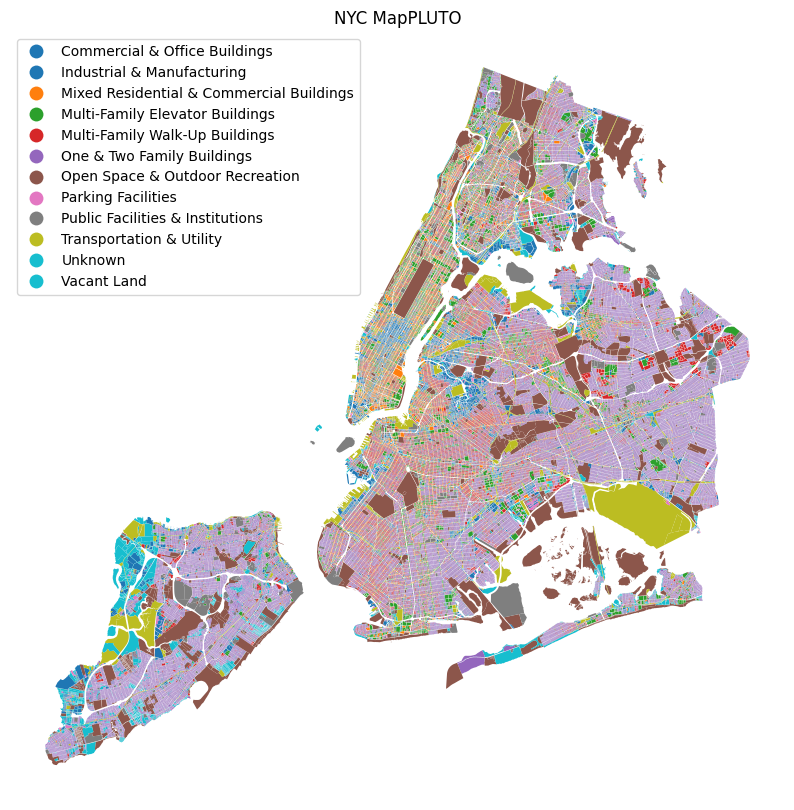

In [28]:
pluto_ogrio.plot(
    column="LandUse", figsize=(10, 10), legend=True, legend_kwds={"loc": "upper left"}
).set_axis_off()
plt.title("NYC MapPLUTO")

## Your turn:

- map a numeric column using a continuous colormap for Queens. See here for a list and discussion of colormaps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
- What patterns emerge?


<Axes: >

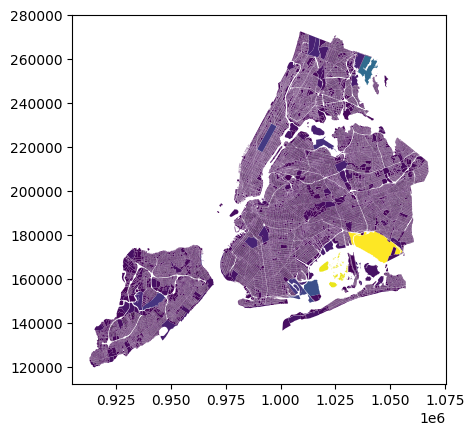

In [30]:
pluto_ogrio.plot(column="LotArea")

In [31]:
pluto_ogrio.Borough

0         MN
1         MN
2         MN
3         MN
4         MN
          ..
856814    SI
856815    SI
856816    SI
856817    SI
856818    SI
Name: Borough, Length: 856819, dtype: object

<Axes: >

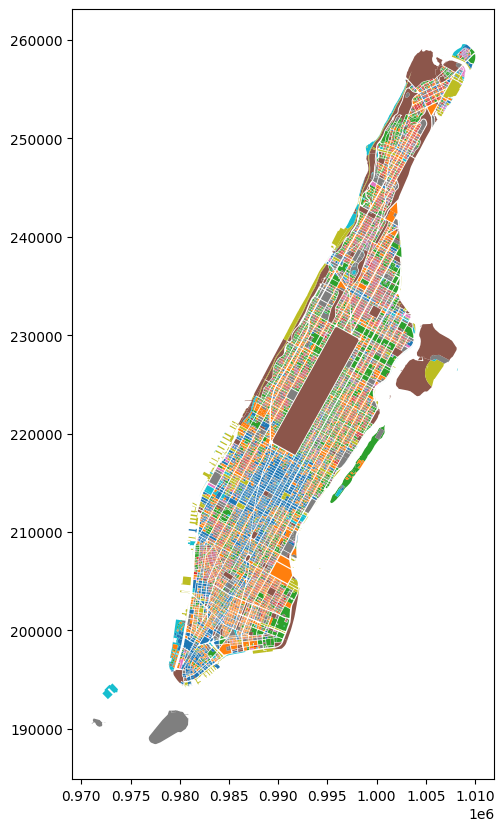

In [32]:
pluto_ogrio[pluto_ogrio.Borough.eq('MN')].plot(column="LandUse", figsize=(10,10))

# prep for interactive mapping


In [18]:
pluto_ogrio.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
pluto_ogrio_wgs = pluto_ogrio.to_crs("epsg:4326")

## visualize a categorical variable


In [20]:
cmap_rgb = {k: list(int(v[i : i + 2], 16) for i in (1, 3, 5)) for k, v in cmap.items()}

NameError: name 'cmap' is not defined

In [38]:
cmap_rgb

{'One & Two Family Buildings': [255, 0, 0],
 'Multi-Family Walk-Up Buildings': [0, 255, 0],
 'Multi-Family Elevator Buildings': [0, 0, 255],
 'Mixed Residential & Commercial Buildings': [255, 0, 255],
 'Commercial & Office Buildings': [0, 255, 255],
 'Industrial & Manufacturing': [255, 255, 0],
 'Transportation & Utility': [128, 128, 128],
 'Public Facilities & Institutions': [128, 0, 0],
 'Open Space & Outdoor Recreation': [0, 128, 0],
 'Parking Facilities': [0, 0, 128],
 'Vacant Land': [128, 0, 128],
 'Unknown': [0, 0, 0]}

In [39]:
len(pluto_ogrio_wgs[pluto_ogrio_wgs["LandUse"].isna()])

0

In [40]:
pluto_ogrio_wgs["LandUse"].fillna("Unknown", inplace=True)

C:\Users\daiyu\AppData\Local\Temp\ipykernel_6848\961482650.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pluto_ogrio_wgs["LandUse"].fillna("Unknown", inplace=True)


## uhoh- observe the above warning- re-write the code to avoid this


## now, we can plot the data using lonboard to create an interactive map


In [41]:
df = pluto_ogrio_wgs[["LandUse", "geometry"]]

layer = PolygonLayer.from_geopandas(
    df[["LandUse", "geometry"]],
    get_fill_color=apply_categorical_cmap(df["LandUse"], cmap=cmap_rgb),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x0000019AFC1C98A0>
[
  [
  …

In [43]:
pluto_ogrio_wgs["LandUse"] = pluto_ogrio_wgs["LandUse"].astype("category")

In [44]:
df = pluto_ogrio_wgs[["LandUse", "geometry"]]

layer = PolygonLayer.from_geopandas(
    df[["LandUse", "geometry"]],
    get_fill_color=apply_categorical_cmap(df["LandUse"], cmap=cmap_rgb),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x0000019AFC1C9B40>
[
  [
  …

In [45]:
pluto_ogrio_wgs[pluto_ogrio_wgs.geometry.isna()]

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry,NumFloorsCluster,color


## visualize a continuous variable


In [46]:
df = pluto_ogrio_wgs[["NumFloors", "geometry"]]

normalizer = LogNorm(1, df.NumFloors.max(), clip=True)
normalized_floors = normalizer(df.NumFloors)

layer = PolygonLayer.from_geopandas(
    df[["NumFloors", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_floors, cmap=PuRd_9),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x0000019AFC1CA380>
[
  [
  …

## your turn: can you make the above show in 3d?

- see here for some tips: https://developmentseed.org/lonboard/latest/examples/overture-maps/#imports


In [36]:
df = pluto_ogrio_wgs[["NumFloors", "geometry"]]

normalizer = LogNorm(1, df.NumFloors.max(), clip=True)
normalized_floors = normalizer(df.NumFloors)

layer = PolygonLayer.from_geopandas(
    # Select only a few attribute columns from the table
    df[["NumFloors", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_floors, cmap=PuRd_9),
    extruded=True,
    get_elevation=pluto_ogrio_wgs["NumFloors"] * 14,
)
m = Map(layer)
m

Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x00000199B5603A00>
[
…

In [49]:
pluto_ogrio_wgs[pluto_ogrio_wgs.YearBuilt < 1970]

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry,NumFloorsCluster,color
0,MN,1,10,101,1000500,10005000003,5,1000,02,1,...,24v1.1,None,40.688766,-74.018682,None,0.0,7.478663e+06,"POLYGON ((-74.01208 40.69205, -74.01215 40.692...",0,#800000
1,MN,97,33,101,1001501,10015013007,15.01,3014,02,1,...,24v1.1,t,40.707789,-74.002009,None,0.0,2.839154e+03,"POLYGON ((-74.00202 40.70791, -74.00198 40.707...",0,#00ff00
2,MN,97,35,101,1001501,10015013007,15.01,3014,02,1,...,24v1.1,t,40.707728,-74.002117,None,0.0,2.531493e+03,"POLYGON ((-74.00213 40.70784, -74.00199 40.707...",0,#ff00ff
3,MN,97,36,101,1001501,10015013007,15.01,3014,02,1,...,24v1.1,t,40.707687,-74.002207,None,0.0,1.825158e+03,"POLYGON ((-74.00231 40.70776, -74.00224 40.707...",0,#ff00ff
4,MN,97,43,101,1001501,10015013007,15.01,3014,02,1,...,24v1.1,t,40.707374,-74.002705,None,0.0,1.057095e+03,"POLYGON ((-74.00271 40.70731, -74.00278 40.707...",0,#ff00ff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856813,SI,8050,72,503,5024800,50248001014,248,1016,31,51,...,24v1.1,None,40.509091,-74.250634,None,0.0,7.766762e+03,"POLYGON ((-74.25065 40.50927, -74.25039 40.509...",0,#ff0000
856814,SI,8050,76,503,5024800,50248001014,248,1016,31,51,...,24v1.1,None,40.509174,-74.250491,None,0.0,3.533919e+03,"POLYGON ((-74.25065 40.50927, -74.25055 40.509...",0,#ff0000
856816,SI,8050,83,503,5024800,50248001014,248,1016,31,51,...,24v1.1,None,40.509152,-74.250189,None,0.0,5.078841e+03,"POLYGON ((-74.24997 40.50916, -74.25004 40.509...",0,#ff0000
856817,SI,8050,86,503,5024800,50248001014,248,1016,31,51,...,24v1.1,None,40.508963,-74.250274,None,0.0,1.318642e+04,"POLYGON ((-74.24983 40.50903, -74.24990 40.509...",0,#ff0000


In [57]:
df = pluto_ogrio_wgs[pluto_ogrio_wgs.YearBuilt < 1970][["NumFloors", "geometry"]]

normalizer = LogNorm(1, df.NumFloors.max(), clip=True)
normalized_floors = normalizer(df.NumFloors)

layer = PolygonLayer.from_geopandas(
    # Select only a few attribute columns from the table
    df[["NumFloors", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_floors, cmap=PuRd_9),
    extruded=True,
    get_elevation=df["NumFloors"] * 14,
)
m = Map(layer)
m

Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x0000019A460734C0>
[
…

# save data


In [47]:
# save out as fgb using geopandas
# pluto_ogrio.to_file("..Data/nyc_mappluto_24v1_1_shp/mappluto.fgb")

In [48]:
# ogr.write_dataframe(pluto_ogrio, "../Data/nyc_mappluto_24v1_1_shp/mappluto_ogr.fgb")